# Classification of the CIFAR-10 dataset

The [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) provides 60000 32x32-pixel images, classified into 10 categories.  The figure below provides a random sample of some images in each category.

During this session, you will learn how to build a Convolutional Neural Network (CNN), which (when trained) will be able to automatically classify new images into one of these categories.  We will make use of the [Keras library](https://www.tensorflow.org/guide/keras) which provides a high-level interface to TensorFlow. Begin by importing the necessary modules.

In [0]:
import os
import time
import datetime
from tqdm import tqdm_notebook

import numpy as np
import pandas
import matplotlib.pyplot as plt
from sklearn import metrics

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms, utils
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from keras.layers import Dense, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout, BatchNormalization
from keras.optimizers import SGD, Adam
from keras.datasets import cifar10
from keras.utils.np_utils import to_categorical
from keras.models import Model
from keras.models import Sequential
from keras.callbacks import EarlyStopping

In [0]:
# !pip install svrg-optimizer-keras
from SVRGoptimizerKeras.optimizer import SVRG

In [0]:
def load_cifar_data():
    """Loads the CIFAR-10 dataset using Keras and preprocess for training."""
    # Download / Load the datasets
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    
    # Normalize the data
    y_train = to_categorical(y_train, 10)
    y_test  = to_categorical(y_test, 10)
    x_train = x_train.astype('float32') / 255
    x_test  = x_test.astype('float32') / 255
    
    # Label vector
    labels = [
        'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 
        'frog', 'horse', 'ship', 'truck'
    ]
    
    return x_train, y_train, x_test, y_test, labels

In [0]:
def show_first_n_images_in_categories(n, images, categories, labels, file_name=None):
    """Plots the first n images in each category from the image data."""
    f, axes = plt.subplots(n, 10, figsize=(11,8))
    
    for i in range(10):
        count = 0
        j = 0
        while count < n and j < 50000:
            if categories[j][i] == 1:
                axes[count,i].imshow(images[j,:,:,:])
                axes[count,i].axis('off')
                if count == 0:
                    axes[count,i].set_title(labels[i])
                count += 1
            j += 1

    if file_name:
        plt.savefig(file_name)
    else:
        plt.show()

In [0]:
def cnn_model(input_shape, num_classes, optimizer):
    """Compile CNN model for a given optimizer."""
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(32,(3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
  
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
 
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [0]:
def train_model(model, x, y, batch_size=32, epochs=10, file_name=None):
    """
    Trains the model on the given data.
    """
    
    stop_early = EarlyStopping(monitor='val_acc', min_delta=0, patience=2, mode='auto')
    
    ret = model.fit(x, y, batch_size=batch_size, epochs=epochs, validation_split=0.2, shuffle=True, 
                    callbacks=[stop_early], verbose = 1)
    
    if file_name:
        model.save(file_name)
    
    return ret

In [0]:
def eval_model(trained_model):
    """Plot learning curves for a given input model."""
    # Plot the evolution of (train/val) accuracy through epochs
    plt.plot(trained_model.history['acc'])
    plt.plot(trained_model.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
  

# Table of content

[1. A first look at the data set](#dataset)<br>

[2. A first naive model](#first_model)<br>

[3. Convolutional Neural Networks](#cnn)<br>
- [3.1 Create your first CNN](#first_cnn)<br>
- [3.2 Influence of parameters on the performance](#cnn_parameters)<br>
- [3.3 Studying predictions](#results)<br>

[4. Pretrained Networks](#pretrained_cnn)<br>


<a id='dataset'></a>
# 1 - A first look at the data set

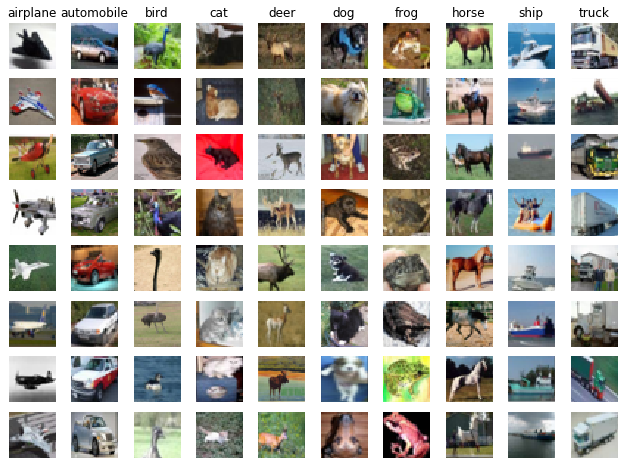

In [9]:
x_train, y_train, x_test, y_test, labels = load_cifar_data()
show_first_n_images_in_categories(8, x_train, y_train, labels, file_name=None)

#Reducing the size of the training set

#x_train = x_train[range(5000),:,:,:]
#y_train = y_train[range(5000)]

#x_test = x_train[range(500),:,:,:]
#y_test = y_train[range(500)]



<a id='first_model'></a>

# 2 - CNN with different optimizers


## SGD

In [10]:
sgd = SGD(lr=0.1, decay=1.0e-6)
cnn_sgd = cnn_model(x_train.shape[1:], 10, optimizer=sgd)
cnn_sgd_trained = train_model(cnn_sgd, x_train, y_train, batch_size=32)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10



40000/40000 [==============================] - 16s 404us/step - loss: 2.1194 - acc: 0.2106 - val_loss: 1.6496 - val_acc: 0.3943
Epoch 2/10
40000/40000 [==============================] - 8s 204us/step - loss: 1.4805 - acc: 0.4684 - val_loss: 1.2620 - val_acc: 0.5537
Epoch 3/10
40000/40000 [==============================] - 8s 206us/step - loss: 1.1554 - acc: 0.5915 - val_loss: 1.0687 - val_acc: 0.6326
Epoch 4/10
40000/40000 [==============================] - 8s 202us/step - loss: 0.9310 - acc: 0.6741 - val_loss: 0.9980 - val_acc: 0.6602
Epoch 5/10
40000/40000 [==============================] - 8s 207us/step - loss: 0.7462 - acc: 0.7403 - val_loss: 0.9983 - val_acc: 0.6544
Epoch 6/10
40000/40000 [==============================] - 8s 196us/step - loss: 0.5789 - acc: 0.7961 - val_loss: 1.0958 - val_acc: 0.6546


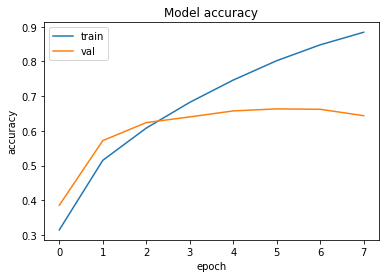

In [0]:
eval_model(cnn_sgd_trained)

## Adam

In [16]:
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
cnn_adam = cnn_model(x_train.shape[1:], 10, optimizer=adam)
cnn_adam_trained = train_model(cnn_sgd, x_train, y_train, batch_size=32)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 9s 218us/step - loss: 0.4403 - acc: 0.8458 - val_loss: 1.1591 - val_acc: 0.6636
Epoch 2/10
40000/40000 [==============================] - 8s 198us/step - loss: 0.3409 - acc: 0.8832 - val_loss: 1.4734 - val_acc: 0.6168
Epoch 3/10
40000/40000 [==============================] - 8s 201us/step - loss: 0.2878 - acc: 0.9038 - val_loss: 1.5597 - val_acc: 0.6496


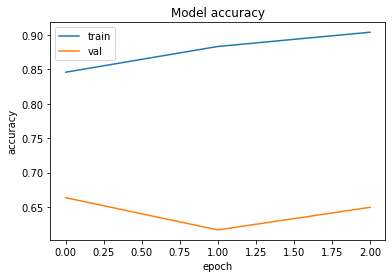

In [17]:
eval_model(cnn_adam_trained)

## Gradient Descent

In [18]:
cnn_gd_trained = train_model(cnn_sgd, x_train, y_train, batch_size=x_train.shape[0]) # GD = SGD with batch = complete train set

Train on 40000 samples, validate on 10000 samples
Epoch 1/10


ResourceExhaustedError: ignored

In [0]:
eval_model(cnn_gd_trained)

## SVRG

In [22]:
svrg = SVRG(lr=0.001)
cnn_svrg = cnn_model(x_train.shape[1:], 10, optimizer=adam)
cnn_svrg_trained = train_model(cnn_svrg, x_train, y_train, batch_size=32)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 10s 245us/step - loss: 1.4059 - acc: 0.4897 - val_loss: 1.0832 - val_acc: 0.6170
Epoch 2/10
40000/40000 [==============================] - 9s 234us/step - loss: 0.9478 - acc: 0.6679 - val_loss: 0.8532 - val_acc: 0.7036
Epoch 3/10
40000/40000 [==============================] - 9s 233us/step - loss: 0.7384 - acc: 0.7395 - val_loss: 0.8772 - val_acc: 0.6982
Epoch 4/10
40000/40000 [==============================] - 9s 228us/step - loss: 0.5749 - acc: 0.7988 - val_loss: 0.7959 - val_acc: 0.7373
Epoch 5/10
40000/40000 [==============================] - 9s 226us/step - loss: 0.4180 - acc: 0.8531 - val_loss: 0.8275 - val_acc: 0.7448
Epoch 6/10
40000/40000 [==============================] - 9s 230us/step - loss: 0.2878 - acc: 0.8982 - val_loss: 0.9487 - val_acc: 0.7341
Epoch 7/10
40000/40000 [==============================] - 9s 233us/step - loss: 0.1922 - acc: 0.9329 - val_loss: 1.1012 -

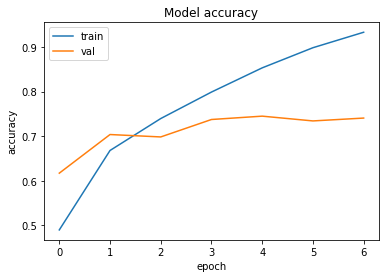

In [23]:
eval_model(cnn_svrg_trained)